# CS445 Final Project: Face Swapping

### Group Members:

Hongxiao Chen, Shuai Wei, Zhexuan Yin

### Motivation
The objective for this project is to be able to capture a facial expression from one image and put it on another person. The motivation for this project is that people may want to capture an expression from another person, and then be able to apply it to another image. By completing this project, we hope to learn how to capture facial expression and blend naturally onto another image. 

## Setup

In [1]:
import cv2
import dlib
import numpy as np
from scipy.spatial import Delaunay
from matplotlib.path import Path
from matplotlib import pyplot as plt

from utils.select_util import pick_points

## Transforming Triangles

The face is divided into triangles and then each triangle is swapped to maintain the proportions and align with the expressions of the new face. To implement such method, we first try to do affine transformation that maps the vertices of a given source to the specified target position. We will use this to map pixels inside each triangle of the mesh.

In [2]:
def get_transform(source_pt, target_pt):
    x = np.ones((3,3))
    y = np.ones((3,3))
    
    x[0:2, :] = source_pt
    y[0:2, :] = target_pt
    
    xt = np.linalg.inv(x)
    T = np.matmul(y, xt)
    T[2, :] = [0,0,1]
    return T

def apply_transform(T, pts):
    
    n = pts.shape[1]
    warp_pt = np.ones((2,n))
    for i in range(n):
        pt = np.ones((3,1))
        pt[0] = pts[0][i]
        pt[1] = pts[1][i]
        pt = np.matmul(T, pt)
        warp_pt[:, i] = pt[:2, 0]
        
    return warp_pt

In [3]:
def bilinear_interpolate(image, x, y):     

    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1

    x0 = np.clip(x0, 0, image.shape[1]-1)
    x1 = np.clip(x1, 0, image.shape[1]-1)
    y0 = np.clip(y0, 0, image.shape[0]-1)
    y1 = np.clip(y1, 0, image.shape[0]-1)

    Ia = image[ y0, x0 ]
    Ib = image[ y1, x0 ]
    Ic = image[ y0, x1 ]
    Id = image[ y1, x1 ]

    wa = (x1-x) * (y1-y)
    wb = (x1-x) * (y-y0)
    wc = (x-x0) * (y1-y)
    wd = (x-x0) * (y-y0)

    values = Ia*wa + Ib*wb + Ic*wc + Id*wd

    return values

In [4]:
def warp(img, source_pt, target_pt, tri):
    
    ntri = tri.shape[0]
    h,w,d = img.shape
    
    t_index = np.ones((h,w)) * (-1)
    xx, yy = np.mgrid[0:h, 0:w]
    p_coord = np.stack((yy.flatten(), xx.flatten()), axis=1)
    
    for t in range(ntri):
        corners = np.vstack([target_pt[:, tri[t, 0]], target_pt[:, tri[t, 1]], target_pt[:, tri[t, 2]]])  
        triangle = Path(corners)
        mask = np.array([triangle.contains_point(p) for p in p_coord]) 
        mask = mask.reshape(h,w)
        t_index[mask] = t
    
    Xsource = np.zeros((2,h*w)) 
    t_index_flat = t_index.flatten()
    
    for t in range(ntri):
        targ = target_pt[:, tri[t]]
        psrc = source_pt[:, tri[t]]
        T = get_transform(targ,psrc)
        pcoords_t = np.transpose(p_coord[t_index_flat == t])
        Xsource[:,t_index_flat==t] = apply_transform(T,pcoords_t)
        
    warp_image = np.zeros(img.shape)
    warp_image[:,:,0] = bilinear_interpolate(img[:, :, 0], Xsource[0], Xsource[1]).reshape(h,w)
    warp_image[:,:,1] = bilinear_interpolate(img[:, :, 1], Xsource[0], Xsource[1]).reshape(h,w)
    warp_image[:,:,2] = bilinear_interpolate(img[:, :, 2], Xsource[0], Xsource[1]).reshape(h,w)
    warp_image = np.clip(warp_image,0.,1.)

    return (warp_image,t_index)

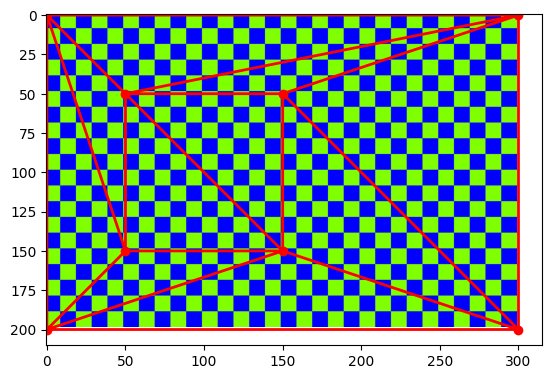

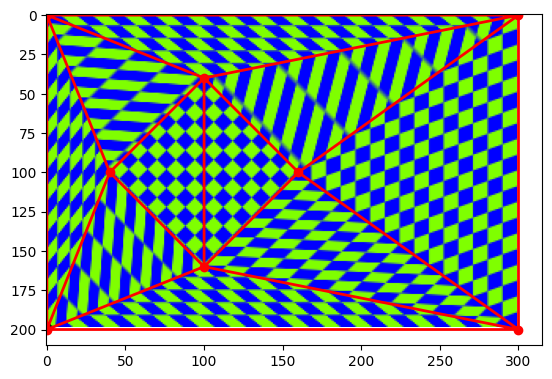

In [5]:
(xx,yy) = np.mgrid[1:200,1:300]
G = np.mod(np.floor(xx/10)+np.floor(yy/10),2)
B = np.mod(np.floor(xx/10)+np.floor(yy/10)+1,2)
image = np.stack((0.5*G,G,B),axis=2)

pts_corners = np.array([[0,300,300,0],[0,0,200,200]])

pts_source = np.array([[50,150,150,50],[50,50,150,150]])
pts_source = np.concatenate((pts_source,pts_corners),axis=1)


pts_target = np.array([[100,160,100,40],[40,100,160,100]])
pts_target = np.concatenate((pts_target,pts_corners),axis=1)


pts_mid = 0.5*(pts_target+pts_source)
trimesh = Delaunay(pts_mid.transpose())
tri = trimesh.simplices.copy()


plt.imshow(image)
plt.triplot(pts_source[0,:],pts_source[1,:],tri,color='r',linewidth=2)
plt.plot(pts_source[0,:],pts_source[1,:],'ro')
plt.show()


(warped,tindex) = warp(image,pts_source,pts_target,tri)
plt.imshow(warped)
plt.triplot(pts_target[0,:],pts_target[1,:],tri,color='r',linewidth=2)
plt.plot(pts_target[0,:],pts_target[1,:],'ro')
plt.show()

## Landmark & Triangulation

We then proceed to use landmark points and Delaunay triangulation to split the image.

In [6]:
def get_landmarks(image, detector, predictor):
  faces = detector(image, 1)
  shape = predictor(image, faces[0])
  landmarks = [(p.x, p.y) for p in shape.parts()]

  return landmarks

In [7]:
def show_landmarks(image, landmarks, index=None):
  points_img = np.copy(image)
  for i, point in enumerate(landmarks):
    if index != None and i == index:
      cv2.circle(points_img, tuple(point), 5, (255, 0, 0), -1)
    else:
      cv2.circle(points_img, tuple(point), 5, (0, 0, 255), -1)
  plt.figure()
  plt.imshow(points_img[:,:,[2,1,0]])

In [8]:
def get_delaunay_triangles(landmarks, img_shape):
  mask = np.zeros(img_shape, dtype=np.uint8)
  subdiv = cv2.Subdiv2D((0, 0, mask.shape[1], mask.shape[0]))

  for p in landmarks:
    subdiv.insert(p)

  triangles = subdiv.getTriangleList()

  # Convert the triangle indices to the actual landmark points
  delaunay_triangles = []
  for t in triangles:
    pt1 = (t[0], t[1])
    pt2 = (t[2], t[3])
    pt3 = (t[4], t[5])

    if all(0 <= x < mask.shape[1] and 0 <= y < mask.shape[0] for (x, y) in (pt1, pt2, pt3)):
      index_pt1 = landmarks.index(pt1)
      index_pt2 = landmarks.index(pt2)
      index_pt3 = landmarks.index(pt3)

      delaunay_triangles.append((index_pt1, index_pt2, index_pt3))

  return delaunay_triangles

In [9]:
def triangle_index_to_triangles(triangle_index, landmarks):
  pt1 = landmarks[triangle_index[0]]
  pt2 = landmarks[triangle_index[1]]
  pt3 = landmarks[triangle_index[2]]
  return np.array([pt1, pt2, pt3], np.int32)

In [10]:
def show_triangles(image, landmarks, triangle_indices):
  triangles_img = np.copy(image)

  triangles = [triangle_index_to_triangles(index, landmarks) for index in triangle_indices]
  cv2.polylines(triangles_img, np.array(triangles), True, (255, 255, 255), thickness=2)

  plt.figure()
  plt.imshow(triangles_img[:,:,[2,1,0]])

## Part 3: Linking & Merging

Finally, we create a new face and merge it into the destination.

In [11]:
def calculate_new_face(img, img2, shape1, shape2, delaunay_triangles1, landmarks1, landmarks2, get_transform=cv2.getAffineTransform, apply_transform=cv2.warpAffine):
  img2_new_face = np.zeros(img2.shape, np.uint8)
  (H1, W1) = shape1
  (H2, W2) = shape2
  for triangle_indices in delaunay_triangles1:
    triangle1 = triangle_index_to_triangles(triangle_indices, landmarks1)
    cropped_tr1_mask = np.zeros((H1, W1), np.uint8)
    
    cv2.fillConvexPoly(cropped_tr1_mask, triangle1, 255)

    triangle2 = triangle_index_to_triangles(triangle_indices, landmarks2)
    cropped_tr2_mask = np.zeros((H2, W2), np.uint8)

    cv2.fillConvexPoly(cropped_tr2_mask, triangle2, 255)

    # Warp triangles
    triangle1 = np.float32(triangle1)
    triangle2 = np.float32(triangle2)
  
    M = get_transform(triangle1, triangle2)
    warped_img_part = apply_transform(img, M, (W2, H2))
    warped_img_part = cv2.bitwise_and(warped_img_part, warped_img_part, mask=cropped_tr2_mask)

    # Remove the overlap part of newly added region
    overlap_mask = cv2.bitwise_and(img2_new_face, warped_img_part)
    warped_img_part = cv2.bitwise_xor(warped_img_part, overlap_mask)
    # Building the destination face
    img2_new_face = cv2.add(img2_new_face, warped_img_part)
  return img2_new_face

In [12]:
def transform_by_landmarks(img1, img2, landmarks1, landmarks2):
  # Calculate triangles
  convexhull2 = cv2.convexHull(np.array(landmarks2))
  delaunay_triangles1 = get_delaunay_triangles(landmarks1, img1.shape)

  # Calculate the new face that will be applied to img2
  img2_new_face = calculate_new_face(img1, img2, img1.shape[:2], img2.shape[:2], delaunay_triangles1, landmarks1, landmarks2, cv2.getAffineTransform, cv2.warpAffine)

  # Remove the face from img2 then paste the new face
  gray = cv2.cvtColor(img2_new_face, cv2.COLOR_BGR2GRAY)
  _, img2_face_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
  # print(convexhull2.shape, convexhull2.max(), convexhull2.min())
  img2_head_noface = cv2.bitwise_and(img2, img2, mask=cv2.bitwise_not(img2_face_mask))
  result = cv2.add(img2_head_noface, img2_new_face)

  # Use seamless clone from cv2
  (x, y, w, h) = cv2.boundingRect(convexhull2)
  center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))

  seamlessclone = cv2.seamlessClone(result, img2, img2_face_mask, center_face2, cv2.NORMAL_CLONE)

  return seamlessclone

In [13]:
def auto_swap_face(img1, img2, is_display = False):
  # Initialization
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor("utils/shape_predictor_68_face_landmarks.dat")

  # Calculate landmarks
  landmarks1 = get_landmarks(img1, detector, predictor)
  landmarks2 = get_landmarks(img2, detector, predictor)

  if (is_display):
    show_landmarks(img1, landmarks1, index=None)
    show_landmarks(img2, landmarks2, index=None)

    delaunay_triangles1 = get_delaunay_triangles(landmarks1, img1.shape)
    show_triangles(img1, landmarks1, delaunay_triangles1)

    delaunay_triangles2 = get_delaunay_triangles(landmarks2, img2.shape)
    show_triangles(img2, landmarks2, delaunay_triangles2)

  return transform_by_landmarks(img1, img2, landmarks1, landmarks2)

In [14]:
def manual_swap_face(img1, img2, is_display = False):
  
  # hand picking, use Q to quit
  landmarks1 = pick_points(img1)
  landmarks2 = pick_points(img2)

  if (is_display):
    show_landmarks(img1, landmarks1, index=None)
    show_landmarks(img2, landmarks2, index=None)

    delaunay_triangles1 = get_delaunay_triangles(landmarks1, img1.shape)
    show_triangles(img1, landmarks1, delaunay_triangles1)

    delaunay_triangles2 = get_delaunay_triangles(landmarks2, img2.shape)
    show_triangles(img2, landmarks2, delaunay_triangles2)

  return transform_by_landmarks(img1, img2, landmarks1, landmarks2)

## Result Display

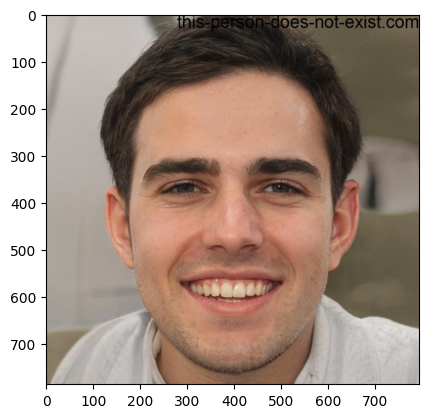

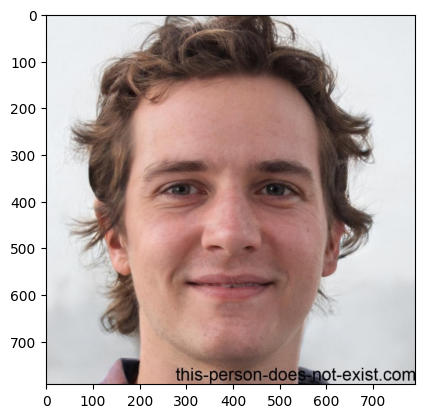

In [15]:
# Import
img1 = cv2.imread("images/test1.jpg")
plt.imshow(img1[:, :, [2, 1, 0]])

plt.figure()
img2 = cv2.imread("images/test2.jpg")
plt.imshow(img2[:, :, [2, 1, 0]])

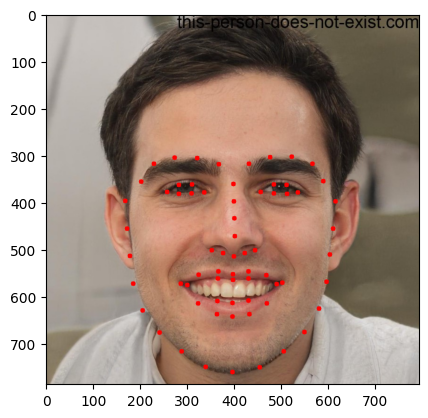

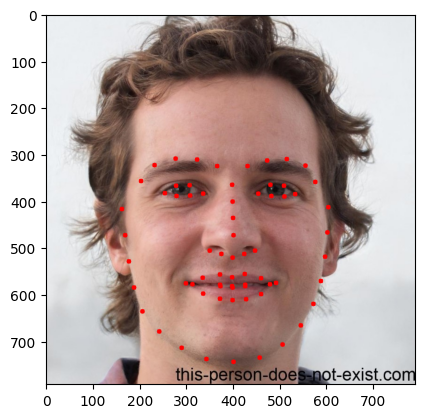

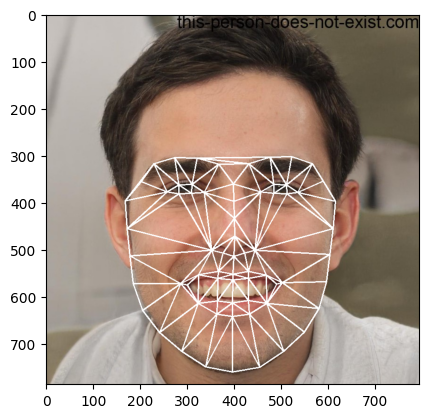

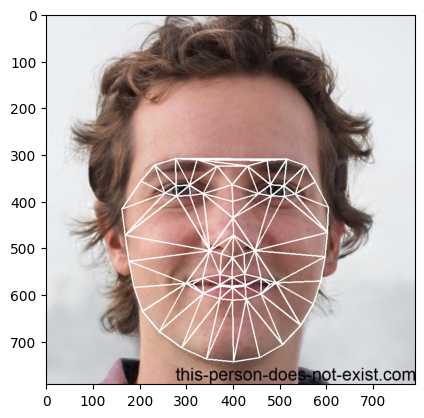

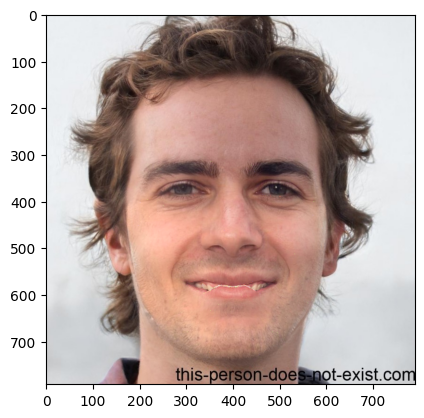

In [16]:
result = auto_swap_face(img1, img2, is_display = True)

plt.figure()
plt.imshow(result[:,:,[2,1,0]])

## Extending: Swapping partial face and manual point selection

### Manual selecting

In [17]:
# Swapping eyes
img_r = cv2.imread("images/robot.jpg")

plt.figure()
img_m = cv2.imread("images/test2.jpg")

<Figure size 640x480 with 0 Axes>

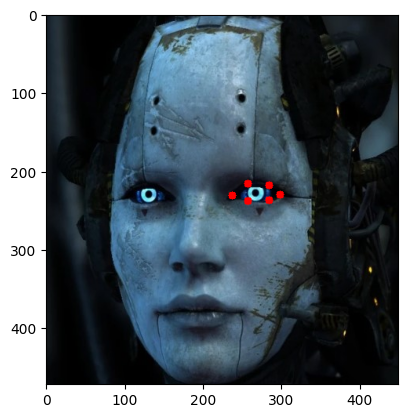

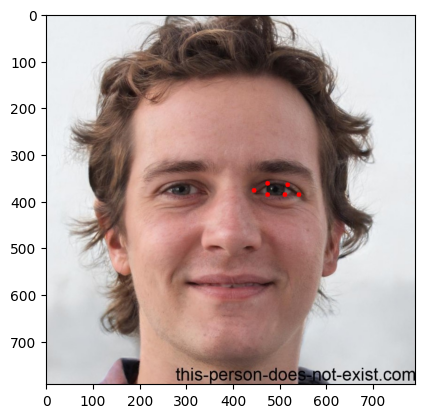

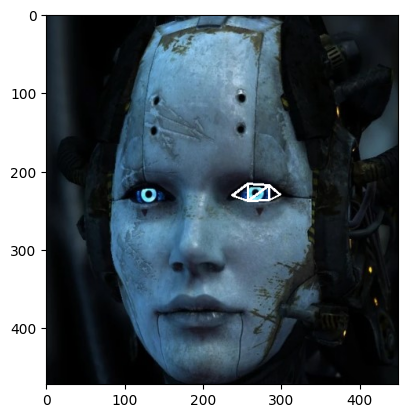

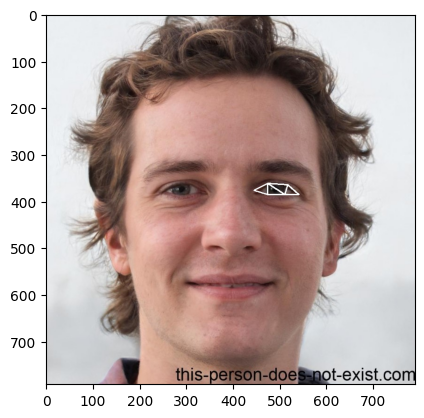

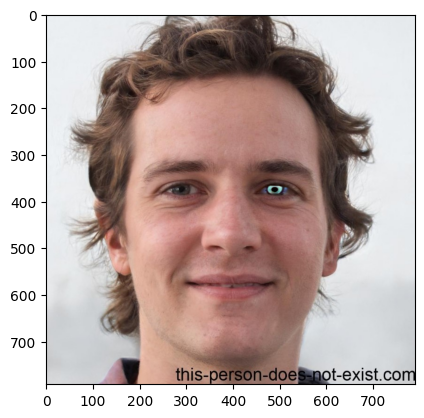

In [18]:
result = manual_swap_face(img_r, img_m, is_display = True)

plt.figure()
plt.imshow(result[:,:,[2,1,0]])

### Face warping

In [19]:
mouth = [48, 54, 60, 64]

# Initialization
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("utils/shape_predictor_68_face_landmarks.dat")

# Calculate landmarks
landmarks1 = get_landmarks(img1, detector, predictor)
landmarks2 = get_landmarks(img2, detector, predictor)

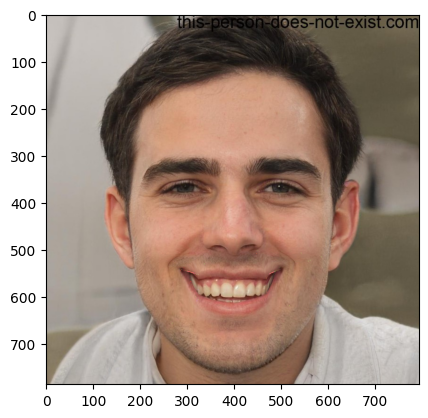

In [20]:
t_landmarks = np.copy(landmarks1)
for i in mouth:
  t_landmarks[i][1] -= 30

res = transform_by_landmarks(img1, img1, landmarks1, t_landmarks)
plt.figure()
plt.imshow(res[:,:,[2,1,0]])